# Notebook - Data Processing & EDA

In [43]:
!pip install textblob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import string
from textblob import TextBlob

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


## Load Trainset & Testset

In [44]:
trainset = pd.read_parquet('../dataset/yelp_review_trainset.parquet')
testset = pd.read_parquet('../dataset/yelp_review_testset.parquet')

## Processing Functions

In [45]:
# 1. Re-Labeling
rating_dict = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}
# 2. Label Dicts
label_dict = {0: "negative", 1: "mixed", 2: "positive"}
# 3. Review Processing
def preprocess_review(review):
    """Ensures the input is a string, converts it to lovercase, removes puncuation, 
    keeps alphabetical words only, remove any whitespaces"""
    if isinstance(review, list):
        review = ' '.join(review)
    review = review.lower()
    review = ''.join([char for char in review if char not in string.punctuation])
    review = ' '.join([word for word in review.split() if word.isalpha()])
    review = ' '.join(review.split())
    return review
# 4. Undersample to balance the class
def undersampling(df):
    df_negative_class = df[df['label'] == 0]
    df_mixed_class = df[df['label'] == 1]
    df_positive_class = df[df['label'] == 2]
    
    # Resample the negative and positive class to match mixed class
    df_negative_class_downsampled = resample(df_negative_class,
                                             replace=False,
                                             n_samples=len(df_mixed_class),
                                             random_state=1)
    
    df_positive_class_downsampled = resample(df_positive_class,
                                             replace=False,
                                             n_samples=len(df_mixed_class),
                                             random_state=1)
    # Combine all classes
    df_balanced = pd.concat([df_negative_class_downsampled, df_mixed_class, df_positive_class_downsampled])
    # Shuffle the dataset
    df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
    
    return df_balanced

## Part A: Process Trainset and Testset

In [46]:
# === Check nulls
display(trainset.isnull().sum().sort_values(ascending = False))

# === Trainset
trainset.label = trainset.label.map(rating_dict)
trainset['text'] = trainset['text'].apply(preprocess_review)
trainset = undersampling(trainset)

# === Testset
testset.label = testset.label.map(rating_dict)
testset['text'] = testset['text'].apply(preprocess_review)

# === Save locally
trainset.to_parquet('../dataset/trainset_pro.parquet')
testset.to_parquet('../dataset/testset_pro.parquet')

# === Get a subset by resampling (small set trial)
subset_trainset = resample(trainset.copy(),replace=False,n_samples=2000,random_state=1)
subset_trainset.to_parquet('../dataset/subset_trainset_pro.parquet')

# === Display the dataset
display(trainset.head(5))
display(testset.head(5))

label    0
text     0
dtype: int64

,label,text
0,0,ive been going to pamelas in its various locat...
1,0,ouch that was my reaction when seeing the bill...
2,0,so from the first time i stepped foot in the d...
3,1,i really like their thin crust pizzas parking ...
4,0,buffet of buffets marathon stop of pmnnthe sto...


,label,text
0,0,i got new tires from them and within two weeks...
1,0,dont waste your time we had two different peop...
2,0,all i can say is the worst we were the only pe...
3,0,i have been to this restaurant twice and was d...
4,0,food was not good at all my husband i ate here...


## Part B: EDA

label
0    130000
1    130000
2    130000
Name: count, dtype: int64

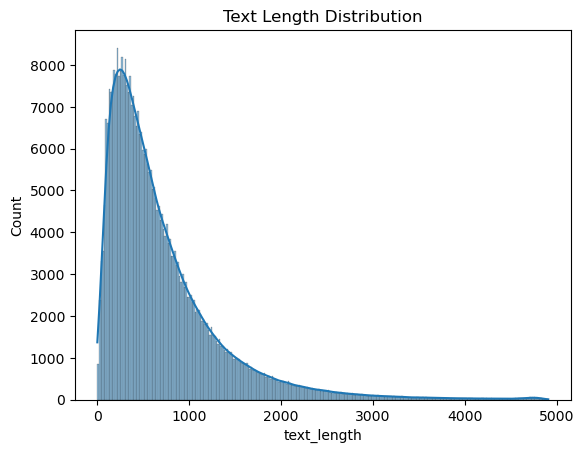

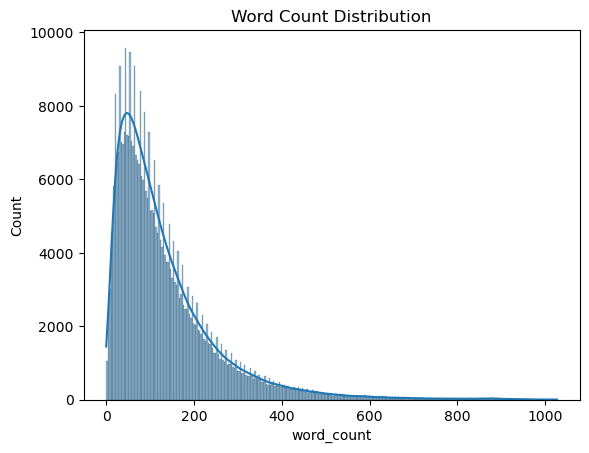

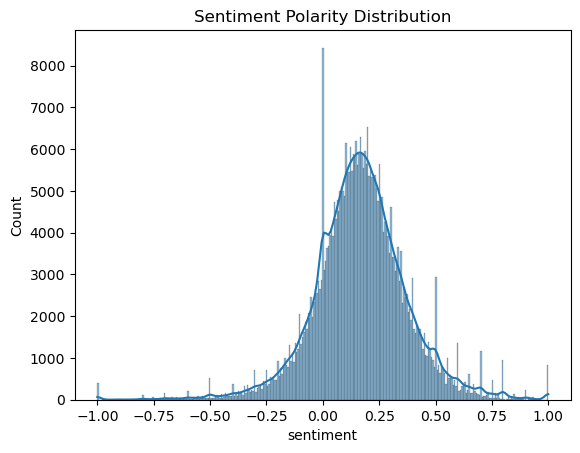

In [42]:
trainset_eda = trainset.copy()
# === 1. Balance Check
display(trainset_eda["label"].value_counts().sort_index())

# === 2. Text Length
trainset_eda['text_length'] = trainset_eda['text'].apply(len)
trainset_eda['word_count'] = trainset_eda['text'].apply(lambda x: len(x.split()))
sns.histplot(trainset_eda['text_length'], kde=True)
plt.title('Text Length Distribution')
plt.show()
sns.histplot(trainset_eda['word_count'], kde=True)
plt.title('Word Count Distribution')
plt.show()

# === 3. Sentiment Check
trainset_eda['sentiment'] = trainset_eda['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.histplot(trainset_eda['sentiment'], kde=True)
plt.title('Sentiment Polarity Distribution')
plt.show()